In [1]:
# coding: UTF-8

import os
import sys
spark_home = os.environ.get('SPARK_HOME', None)
sys.path.insert(0, "/opt/spark/python")
sys.path.insert(0, "/opt/spark/python/lib/py4j-0.10.7-src.zip")
exec(open(os.path.join("/opt/spark/python/pyspark/shell.py")).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.4.6
      /_/

Using Python version 3.6.7 (default, Oct 22 2018 11:32:17)
SparkSession available as 'spark'.


In [2]:
sc

<SparkContext master=spark://192.168.11.9:7077 appName=pyspark-shell>

In [3]:
spark = SparkSession.builder.getOrCreate()

In [5]:
import json

base_meter  = spark.read.csv("/home/okano/pyspark_test/switch-bot-data/*.csv",header=True,inferSchema=True)

In [101]:
base_meter.registerTempTable("meter")

In [102]:
base_meter.printSchema()

root
 |-- exec_time: timestamp (nullable = true)
 |-- device_name: string (nullable = true)
 |-- temperature: double (nullable = true)
 |-- humidity: integer (nullable = true)



In [103]:
base_meter.show(5)

+-------------------+-----------+-----------+--------+
|          exec_time|device_name|temperature|humidity|
+-------------------+-----------+-----------+--------+
|2022-01-26 00:00:06| north_room|       16.7|      45|
|2022-01-26 00:00:06| south_room|       10.5|      59|
|2022-01-26 00:06:06| north_room|       16.9|      45|
|2022-01-26 00:06:06| south_room|       10.5|      59|
|2022-01-26 00:12:06| north_room|       17.0|      45|
+-------------------+-----------+-----------+--------+
only showing top 5 rows



In [104]:
from pyspark.sql.functions import date_format

spark.sql("\
    select device_name,exec_time,date_format(exec_time,'yyyy-MM-dd') as date, \
        date_format(exec_time,'yyyy-MM-dd HH') as date_hour, \
        temperature \
    from meter \
").registerTempTable("temperature")

spark.sql("select * from temperature").show(5)

+-----------+-------------------+----------+-------------+-----------+
|device_name|          exec_time|      date|    date_hour|temperature|
+-----------+-------------------+----------+-------------+-----------+
| north_room|2022-01-26 00:00:06|2022-01-26|2022-01-26 00|       16.7|
| south_room|2022-01-26 00:00:06|2022-01-26|2022-01-26 00|       10.5|
| north_room|2022-01-26 00:06:06|2022-01-26|2022-01-26 00|       16.9|
| south_room|2022-01-26 00:06:06|2022-01-26|2022-01-26 00|       10.5|
| north_room|2022-01-26 00:12:06|2022-01-26|2022-01-26 00|       17.0|
+-----------+-------------------+----------+-------------+-----------+
only showing top 5 rows



In [105]:
avg_df= spark.sql(" \
    select date, date_hour, \
      avg( case when device_name = 'north_room' then temperature end) as north_temp, \
      avg( case when device_name = 'south_room' then temperature end) as south_temp \
    from temperature \
    group by date,date_hour \
    order by date_hour \
")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe9667d7048>,
      dtype=object)

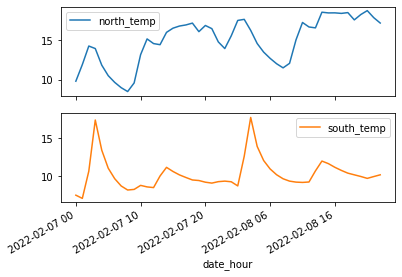

In [106]:
%matplotlib inline
pd_avg_df = avg_df.filter("date >= '2022-02-07' AND date <= '2022-02-08'").toPandas()
pd_avg_df.plot.line(x='date_hour',subplots=True)

In [107]:
avg_df.rdd.getNumPartitions()

200